In [5]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from scipy import stats
from statsmodels.stats.multitest import multipletests
import networkx as nx
import glob


In [250]:


class MTBLSDataset:
    '''
    Class to load and QC metabolon data
    '''
    def __init__(self, file_path, id, node_name, md_group, md_filter, maf_sheet=0):
        self.file_path = file_path
        self.raw_data = None
        self.compound_mappers = None
        self.processed_data = None
        self.metadata = None
        self.id = id
        self.node_name = node_name
        self.md_group = md_group
        self.md_filter = md_filter
        self.pval_df = None
        self.DA_metabolites = None
        self.maf_sheet = maf_sheet

        self.read_data(file_path)
        self.preprocess_data()
        self.da_testing()
        
    def read_data(self, file_path):
        """
        Read in the metabolights format data
        """
        # read in the maf files
        files = glob.glob(file_path + '/*_maf.tsv')
        # for now only use one maf file

        data = pd.read_csv(files[self.maf_sheet], sep='\t')
        self.raw_data = data

        metadata = pd.read_csv(file_path + '/s_' + self.id + '.txt', sep = '\t', encoding='unicode_escape')

        self.metadata = metadata
        self.metadata['Sample Name'] = self.metadata['Sample Name'].astype(str)
        print(metadata[['Sample Name', self.md_group]].head())

        return data, metadata

    def preprocess_data(self):
        data_filt = self.raw_data.copy()

        # set chebi as index
        data_filt = data_filt[data_filt['database_identifier'].notna()]
        data_filt.index = data_filt['database_identifier']

        # keep only abundance data filtering on samples
        samples = self.metadata['Sample Name'].tolist()
        data_filt = data_filt.iloc[:, data_filt.columns.isin(samples)]

        # ensure all data is numeric
        data_filt = data_filt.apply(pd.to_numeric, errors='coerce')

        # Transpose
        data_filt = data_filt.T

        # There weill be QC samples so better filter on metadata at this point
        md_dict = dict(zip(self.metadata['Sample Name'], self.metadata[self.md_group]))
        # add metadata column
        data_filt['Group'] = data_filt.index.map(md_dict)

    #     # filter on metadata
        data_filt = data_filt[data_filt['Group'].isin(self.md_filter)]
        data_filt = data_filt.drop(columns=['Group'])

        # Missingness checks 
        # replace empty strings with NaN
        data_filt = data_filt.replace(['', ' '], np.nan)
        # Delete colums and rows where all values are missing
        data_filt = data_filt.dropna(axis=0, how='all')
        data_filt = data_filt.dropna(axis=1, how='all')

        # Delete columns and rows where all values are 0
        data_filt = data_filt.loc[:, (data_filt != 0).any(axis=0)]
        data_filt = data_filt.loc[(data_filt != 0).any(axis=1), :]

        data_filt = data_filt.dropna(axis=1, thresh=0.5*data_filt.shape[0])
        missing_pct = data_filt.isnull().sum().sum() / (data_filt.shape[0] * data_filt.shape[1]) * 100
        print(f"Missingness: {missing_pct:.2f}%")

        # impute missing values
        imputer = KNNImputer(n_neighbors=2, weights="uniform").set_output(transform="pandas")
        data_imputed = imputer.fit_transform(data_filt)

        # log transformation
        data_imputed = np.log(data_imputed + 1)

        # standardize
        scaler = StandardScaler().set_output(transform="pandas")
        data_scaled = scaler.fit_transform(data_imputed)

        data_scaled['Group'] = data_scaled.index.map(md_dict)
        self.processed_data = data_scaled

        return data_scaled
    
    def plot_qc(self):
        print(self.processed_data.isna().sum().sum())
        # PCA biplot
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(self.processed_data.iloc[:, :-1])

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        sns.scatterplot(
            x=pca_result[:, 0], y=pca_result[:, 1],
            hue="Group",
            data=self.processed_data,
            alpha=0.7,
            ax=ax1
        )

        # normality every nth feature
        normaliser = 10 * self.processed_data.shape[1]
        data_long = self.processed_data.melt(id_vars='Group')
        sns.boxplot(data=data_long.iloc[0:normaliser, :], ax=ax2, hue='Group', x='variable', y='value')
        ax2.axhline(0, color='red', linestyle='--')
        plt.show()

    def da_testing(self):

        # t-test for two groups
        groups = self.processed_data['Group'].unique()
        stat, pvals = stats.ttest_ind(self.processed_data[self.processed_data['Group'] == groups[0]].iloc[:, :-1],
                        self.processed_data[self.processed_data['Group'] == groups[1]].iloc[:, :-1],
                        alternative='two-sided', nan_policy='raise')
        pval_df = pd.DataFrame(pvals, index=self.processed_data.columns[:-1], columns=['P-value'])
        self.pval_df = pval_df

        # fdr correction 
        pval_df['FDR_P-value'] = multipletests(pvals, method='fdr_bh')[1]

        # return significant metabolites
        self.DA_metabolites = pval_df[pval_df['FDR_P-value'] < 0.05].index.tolist()
        print(f"Number of differentially abundant metabolites: {len(self.DA_metabolites)}") 

        # generate tuples for nx links
        self.connection = [(self.node_name, met) for met in self.DA_metabolites]

    # def get_class_info(self, hmdbs=None):

    #     if hmdbs == None:
    #         hmdbs = self.compound_mappers['HMDB'].tolist()
    #     hmdb_ids = ['hmdb:' + str(hmdb) for hmdb in hmdbs if not pd.isna(hmdb)]
    #     print(hmdb_ids)
    #     api_url = "https://rampdb.nih.gov/api/chemical-classes"
    #     request_body = {
    #     "metabolites": hmdb_ids
    #     }
    #     response = requests.post(api_url, json=request_body, verify=False)
    #     resp_json = response.json()['data']
    #     resp_df = pd.DataFrame.from_dict(resp_json)
    #     return resp_df
    




In [128]:
s014 = MTBLSDataset(
    file_path = 'Studies/MTBLS2014', 
    id = 'MTBLS2014', 
    node_name = 'MTBLS2014', 
    md_group = 'Factor Value[Disease]', 
    md_filter = ['Healthy', 'Patient (+) SARS-CoV-2'])

                Sample Name   Factor Value[Disease]
0  03JUN2020_COV_AAA_PL_021                 Healthy
1  03JUN2020_COV_AAA_PL_024                 Healthy
2  03JUN2020_COV_AAA_PL_029  Patient (+) SARS-CoV-2
3  03JUN2020_COV_AAA_PL_032  Patient (+) SARS-CoV-2
4  03JUN2020_COV_AAA_PL_035  Patient (+) SARS-CoV-2
                     03JUN2020_COV_AAA_PL_021  03JUN2020_COV_AAA_PL_024  \
database_identifier                                                       
CHEBI:35621                               5.6                      12.1   
CHEBI:27389                               1.5                       1.3   
CHEBI:16865                               0.2                       0.2   
CHEBI:16449                             166.5                     156.4   
CHEBI:37024                               0.8                       0.9   

                     03JUN2020_COV_AAA_PL_029  03JUN2020_COV_AAA_PL_032  \
database_identifier                                                       
CHEBI:35621 

In [129]:
s2014.processed_data.shape

(49, 32)

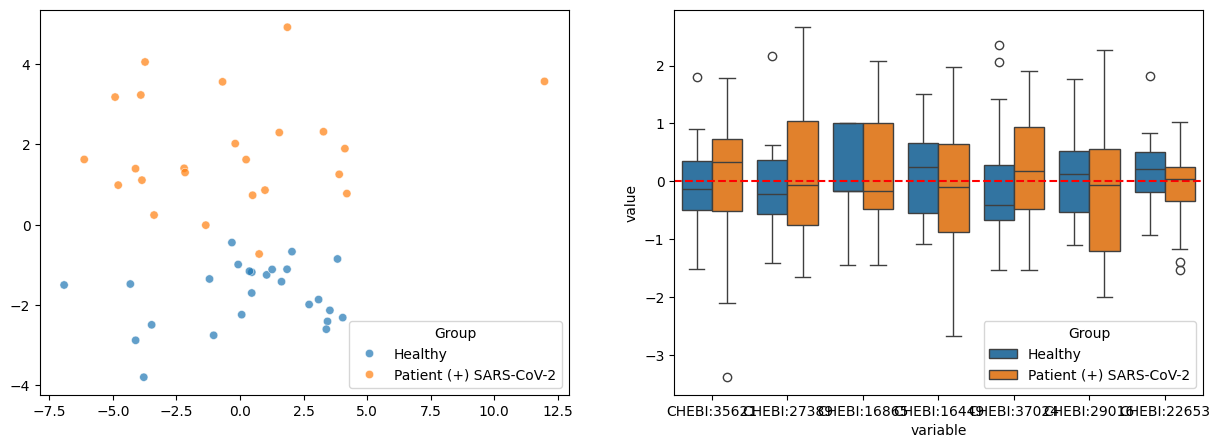

In [130]:
s2014.plot_qc()

In [133]:
# metadata does not match maf sheet - manually remove dates in metadata file
# s2291_md = pd.read_csv('Studies/MTBLS2291/s_MTBLS2291.txt', sep='\t')
# s2291_md['Sample Name'] = s2291_md['Sample Name'].str[9:]
# s2291_md.to_csv('Studies/MTBLS2291/s_MTBLS2291.txt', sep='\t', index=False)

In [134]:
s2291 = MTBLSDataset(
    file_path = 'Studies/MTBLS2291', 
    id = 'MTBLS2291', 
    node_name = 'MTBLS2291', 
    md_group = 'Factor Value[Disease severity]', 
    md_filter = ['Negative COVID-19', 'Severe COVID-19'])

          Sample Name Factor Value[Disease severity]
0  CovidMild_P274_P_2            Non-severe COVID-19
1  CovidMild_P274_P_3            Non-severe COVID-19
2  CovidMild_P274_P_4            Non-severe COVID-19
3  CovidMild_P275_P_2            Non-severe COVID-19
4  CovidMild_P275_P_3            Non-severe COVID-19
                        Blank_P_1     Blank_P_2     Blank_P_3  \
database_identifier                                             
CHEBI:89605          4.398641e+07           NaN           NaN   
CHEBI:36219                   NaN           NaN           NaN   
CHEBI:36219          3.849794e+07  5.886447e+07  4.334992e+07   
CHEBI:32315          9.152517e+07           NaN           NaN   
CHEBI:28282                   NaN           NaN           NaN   

                     QCPool_Set1_P_3  QCPool_Set1_P_4  QCPool_Set2_P_3  \
database_identifier                                                      
CHEBI:89605                      NaN              NaN              NaN   
CHEB

In [119]:
s2291.processed_data.shape

(125, 143)

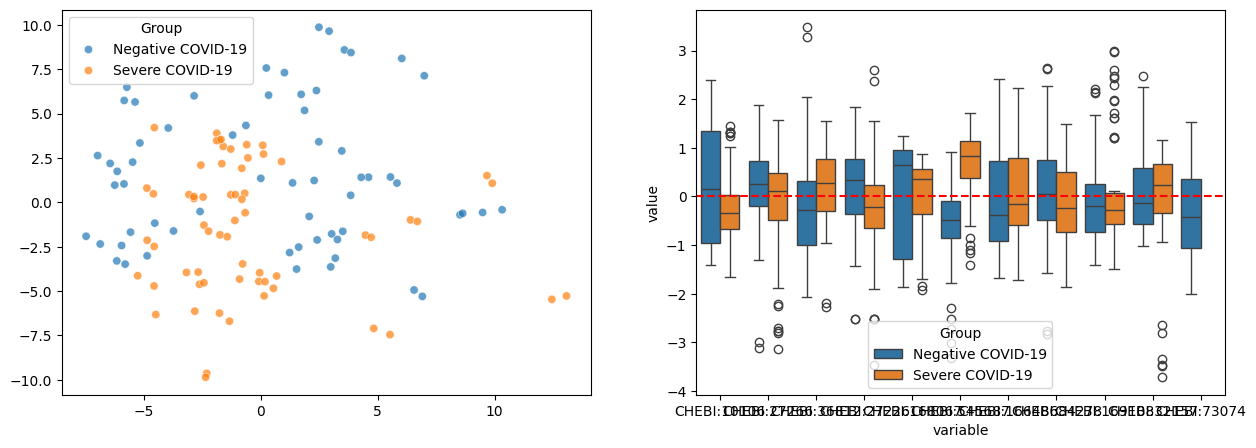

In [135]:
s2291.plot_qc()

In [138]:
# metadata does not match maf sheet - manually remove dates in metadata file
# s2349_md = pd.read_csv('Studies/MTBLS2349/s_MTBLS2349.txt', sep='\t')
# s2349_md['Sample Name'] = s2349_md['Sample Name'].str[9:]
# s2349_md.to_csv('Studies/MTBLS2349/s_MTBLS2349.txt', sep='\t', index=False)

In [146]:
s2349 = MTBLSDataset(
    file_path = 'Studies/MTBLS2349', 
    id = 'MTBLS2349', 
    node_name = 'MTBLS2349', 
    md_group = 'Factor Value[Disease severity]', 
    md_filter = ['Negative COVID-19', 'Severe COVID-19'])

            Sample Name Factor Value[Disease severity]
0  CovidSwabPos_242_P_4            Non-severe COVID-19
1  CovidSwabPos_242_P_2            Non-severe COVID-19
2  CovidSwabPos_231_P_4            Non-severe COVID-19
3  CovidSwabPos_231_P_3            Non-severe COVID-19
4  CovidSwabPos_233_P_2            Non-severe COVID-19
                     Blank_P_1  Blank_P_2  Blank_P_3  QCPool_Set1_P_3  \
database_identifier                                                     
CHEBI:62755                NaN        NaN        NaN              NaN   
CHEBI:62755                NaN        NaN        NaN              NaN   
CHEBI:62755                NaN        NaN        NaN              NaN   
CHEBI:62755                NaN        NaN        NaN              NaN   
CHEBI:62755                NaN        NaN        NaN              NaN   

                     QCPool_Set1_P_4  QCPool_Set2_P_3  QCPool_Set2_P_4  
database_identifier                                                     
CHEBI:62755 

In [140]:
s2349.processed_data.shape

(0, 44)

In [148]:
s6844 = MTBLSDataset(
    file_path = 'Studies/MTBLS6844', 
    id = 'MTBLS6844', 
    node_name = 'MTBLS6844', 
    md_group = 'Factor Value[Disease]', 
    md_filter = ['Severe', 'Mild'])

  Sample Name Factor Value[Disease]
0       Blank                   NaN
1         PBS                   NaN
2  Calibrants                   NaN
3          QC                   NaN
4       MILD1                  Mild
                      MILD1  MILD2  MILD3  MILD4   MILD5   MILD6  MILD7  \
database_identifier                                                       
CHEBI:64483           15.60   9.74   5.99   9.96    7.82    6.79   6.01   
CHEBI:64563          115.00  81.20  92.10  89.90  116.00  126.00  75.40   
CHEBI:64560            2.81   2.06   2.36   2.29    2.28    2.46   1.79   
CHEBI:72737            2.16   1.49   1.78   1.88    3.18    1.96   1.57   
CHEBI:64561           37.80  24.20  26.60  30.90   35.50   39.00  24.60   

                      MILD8  MILD9  MILD10  ...  SEVERE8  SEVERE9  SEVERE10  \
database_identifier                         ...                               
CHEBI:64483           10.60   7.50    6.19  ...    20.70     4.46      7.07   
CHEBI:64563          

In [149]:
s6844.processed_data.shape

(37, 117)

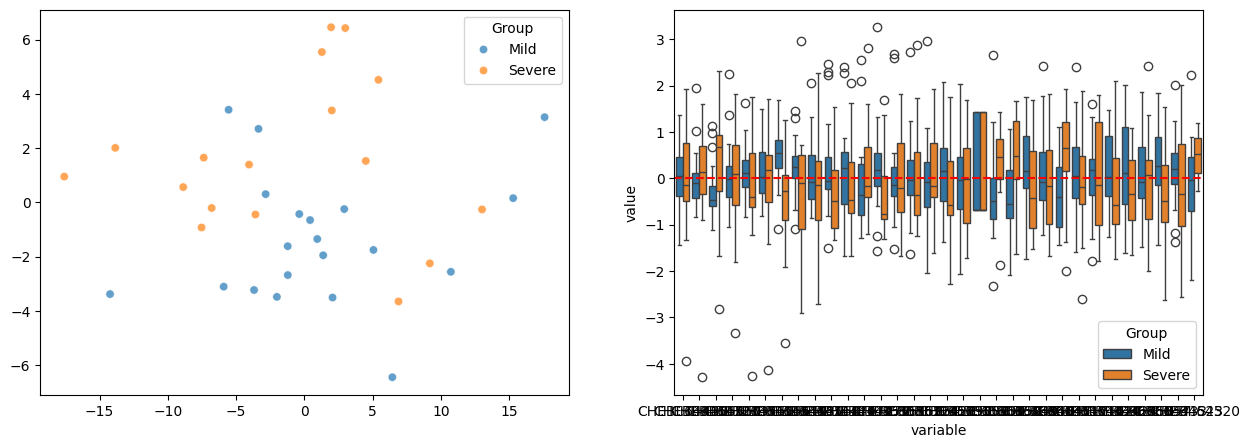

In [150]:
s6844.plot_qc()

In [154]:
s718 = MTBLSDataset(
    file_path = 'Studies/MTBLS718', 
    id = 'MTBLS718', 
    node_name = 'MTBLS718', 
    md_group = 'Factor Value[Condition]', 
    md_filter = ['COVID-19', 'Healthy Control'])

  Sample Name Factor Value[Condition]
0     IP-0793      Pre-COVID-19 viral
1     IP-3398                COVID-19
2     IP-3400                COVID-19
3      MP-006                COVID-19
4     IP-0929          Unwell Control
                       IP-3347      IP-1225      IP-3340      IP-1004  \
database_identifier                                                     
CHEBI:156331         141096.21  2344.872321  79047.81208  5792.163205   
CHEBI:156331               NaN          NaN          NaN          NaN   
CHEBI:156331               NaN          NaN          NaN          NaN   

                         IP-4417      IP-0441      IP-3592     IP-1838  \
database_identifier                                                      
CHEBI:156331         257923.5915  18251.12636  59461.90835  23619.3012   
CHEBI:156331                 NaN          NaN          NaN         NaN   
CHEBI:156331                 NaN          NaN          NaN         NaN   

                          MP-001   

C:\Users\cw2019\AppData\Local\Temp\ipykernel_10828\3405448089.py:29: DtypeWarning: Columns (0,1,2,3,7,14) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(files[0], sep='\t')


In [197]:
s718.processed_data.shape

(122, 2)

In [246]:
s1866 = MTBLSDataset(
    file_path = 'Studies/MTBLS1866', 
    id = 'MTBLS1866', 
    node_name = 'MTBLS1866', 
    md_group = 'Factor Value[Medical case]', 
    md_filter = ['HEALTHY', 'COVID-19'])

  Sample Name Factor Value[Medical case]
0           1                   COVID-19
1          41                   COVID-19
2         101                   COVID-19
3          62                   COVID-19
4         104                   COVID-19
Missingness: 0.00%
Number of differentially abundant metabolites: 0


c:\Users\cw2019\.conda\envs\py12\Lib\site-packages\scipy\stats\_axis_nan_policy.py:563: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


In [195]:
s1866.processed_data

,CHEBI:183261,CHEBI:86391,CHEBI:183260,CHEBI:183262,CHEBI:79053,CHEBI:183263,CHEBI:183264,CHEBI:183265,CHEBI:156286,CHEBI:16070,...,CHEBI:6032,CHEBI:18237,CHEBI:28300,CHEBI:26271,CHEBI:27897,CHEBI:6650,CHEBI:89633,CHEBI:40992,CHEBI:70979,Group
4,-0.974283,-0.883790,-1.993352,-0.841106,-0.571377,0.013904,1.771605,0.235029,1.278896,-0.091972,...,-0.564283,-0.749634,0.255755,-0.840057,-1.075585,-0.659349,-0.728718,-0.175970,-0.727229,COVID-19
9,-0.907786,-0.452459,0.106250,-0.064224,-0.332957,1.190322,-1.031696,0.816514,0.447454,0.111735,...,3.074247,1.091662,3.157206,5.383824,2.605144,1.919363,-0.728718,3.840104,-0.727229,COVID-19
12,-1.151059,-0.165554,-0.066595,0.110365,0.019128,-0.562710,0.562763,-0.412231,1.734549,0.224962,...,-0.484989,-0.749634,-0.099024,-0.824216,0.520619,-0.210237,-0.728718,-0.004272,-0.727229,COVID-19
13,-1.807114,1.461410,1.798353,-0.762490,0.143631,4.827091,0.099952,1.790562,1.519237,0.696464,...,-0.500811,-0.749634,-0.656482,-0.840057,0.689190,-0.659349,-0.728718,-0.075442,-0.727229,COVID-19
14,-0.987192,-1.263465,0.986440,0.507676,-0.130879,0.325598,-1.031696,0.444292,1.720124,0.297323,...,-0.524044,0.945259,0.240736,1.742781,-0.027667,0.572731,-0.728718,-0.334382,-0.727229,COVID-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SA 9,-0.383236,-0.444053,-1.944167,1.787615,-1.209419,0.843817,0.456699,1.793395,0.897274,0.723706,...,-0.542715,-0.749634,-1.006714,0.366253,0.912079,-0.273097,-0.728718,-0.836697,0.073579,HEALTHY
SA 10,-0.557043,0.653322,0.373073,1.130107,-0.629992,0.224212,-0.173980,1.585125,0.239026,-2.227018,...,-0.431006,0.219146,-0.820697,0.926542,0.706126,0.035209,0.103729,-0.844700,-0.727229,HEALTHY
SA 11,-0.284192,-1.348159,-1.426261,1.810327,-1.333612,0.020449,0.063856,0.611031,0.316414,-2.227018,...,0.228748,-0.716109,-1.006714,0.954139,0.959588,-0.261639,-0.417572,-0.474239,1.867922,HEALTHY
SA 12,-0.609207,-1.394785,-1.908361,0.339019,-1.551571,0.349477,0.452493,1.061313,0.102711,0.285037,...,-0.631749,-0.749634,-0.979534,0.158461,0.992024,-0.381754,-0.728718,-0.868695,-0.727229,HEALTHY


0


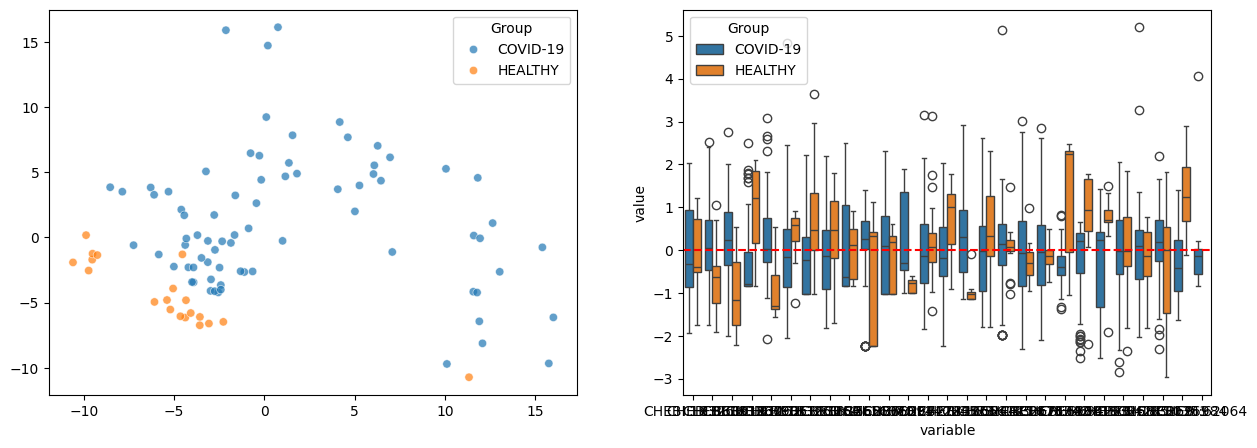

In [245]:
s1866.plot_qc()

In [240]:
s2224 = MTBLSDataset(
    file_path = 'Studies/MTBLS2224', 
    id = 'MTBLS2224', 
    node_name = 'MTBLS2224', 
    md_group = 'Factor Value[COVID Infection]', 
    md_filter = ['Positive', 'Negative'])

  Sample Name Factor Value[COVID Infection]
0        QC-3                           NaN
1        QC-4                           NaN
2        QC-5                           NaN
3        QC-6                           NaN
4        QC-7                           NaN
                    database_identifier chemical_formula             smiles  \
database_identifier                                                           
CHEBI:27389                 CHEBI:27389          C4H9NO2       CC(CN)C(O)=O   
CHEBI:15862                 CHEBI:15862            C2H7N                CCN   
CHEBI:19475                 CHEBI:19475         C5H11NO2      CCCC(N)C(O)=O   
CHEBI:16830                 CHEBI:16830             CH5N                 CN   
CHEBI:30763                 CHEBI:30763           C7H6O3  OC(=O)c1ccc(O)cc1   

                                                                 inchi  \
database_identifier                                                      
CHEBI:27389          InChI=1S/C4H9

In [241]:
s2224.processed_data.shape

(80, 377)

0


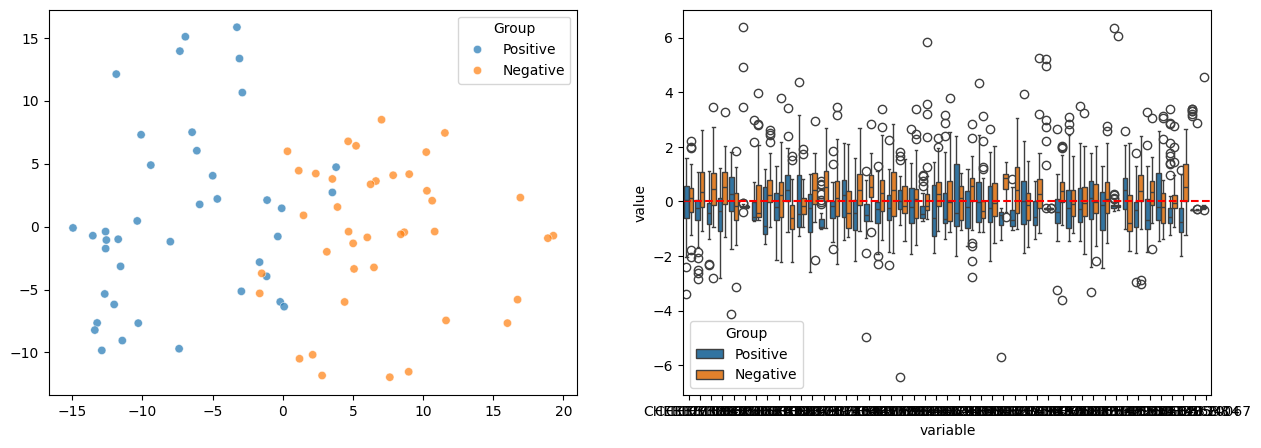

In [242]:
s2224.plot_qc()

In [237]:
s2336 = MTBLSDataset(
    file_path = 'Studies/MTBLS2336', 
    id = 'MTBLS2336', 
    node_name = 'MTBLS2336', 
    md_group = 'Factor Value[Disease]', 
    md_filter = ['COVID-19', 'Healthy (control)'])

     Sample Name Factor Value[Disease]
0  COVID_ANN_001              COVID-19
1  COVID_ANN_002              COVID-19
2  COVID_ANN_003              COVID-19
3  COVID_ANN_004              COVID-19
4  COVID_ANN_005              COVID-19
                    database_identifier chemical_formula  \
database_identifier                                        
CHEBI:15603                 CHEBI:15603         C6H13NO2   
CHEBI:17191                 CHEBI:17191         C6H13NO2   
CHEBI:16414                 CHEBI:16414         C5H11NO2   
CHEBI:16977                 CHEBI:16977          C3H7NO2   
CHEBI:15366                 CHEBI:15366           C2H4O2   

                                       smiles  \
database_identifier                             
CHEBI:15603              CC(C)C[C@H](N)C(O)=O   
CHEBI:17191          OC([C@H]([C@H](CC)C)N)=O   
CHEBI:16414               CC(C)[C@H](N)C(O)=O   
CHEBI:16977                   C[C@H](N)C(O)=O   
CHEBI:15366                           CC(O)=O   

 

In [238]:
s2336.processed_data.shape

(68, 21)

0


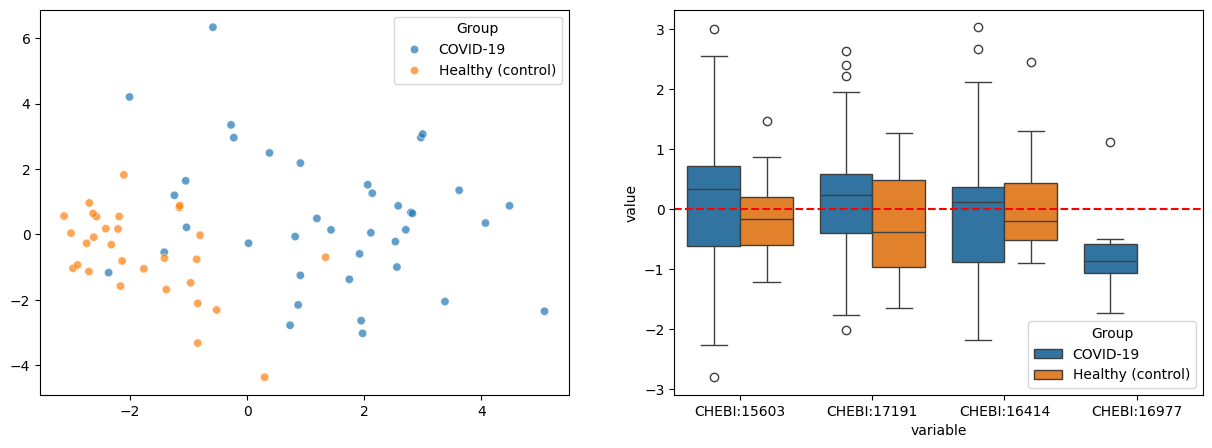

In [239]:
s2336.plot_qc()

In [214]:
s2542 = MTBLSDataset(
    file_path = 'Studies/MTBLS2542', 
    id = 'MTBLS2542', 
    node_name = 'MTBLS2542', 
    md_group = 'Factor Value[Disease severity]', 
    md_filter = ['Mild', 'Death'],
    maf_sheet=2)

              Sample Name Factor Value[Disease severity]
0  20P02820001_BEHC18_NEG                           Mild
1  20P02820001_BEHC18_POS                           Mild
2  20P02820002_BEHC18_NEG                           Mild
3  20P02820002_BEHC18_POS                           Mild
4  20P02820006_BEHC18_NEG                          Death
                     20P02820216_BEHC18_NEG  20P02820217_BEHC18_NEG  \
database_identifier                                                   
CHEBI:30769                    3.104141e+07            6.250293e+07   
CHEBI:30915                    2.859075e+07            5.928731e+07   
CHEBI:167715                   1.765745e+06            3.765748e+06   
CHEBI:16995                    7.455836e+05            6.064137e+06   
CHEBI:32806                    3.371680e+06            3.084555e+06   

                     20P02820215_BEHC18_NEG  20P02820224_BEHC18_NEG  \
database_identifier                                                   
CHEBI:30769       

In [215]:
s2542.processed_data.shape

(70, 300)

0


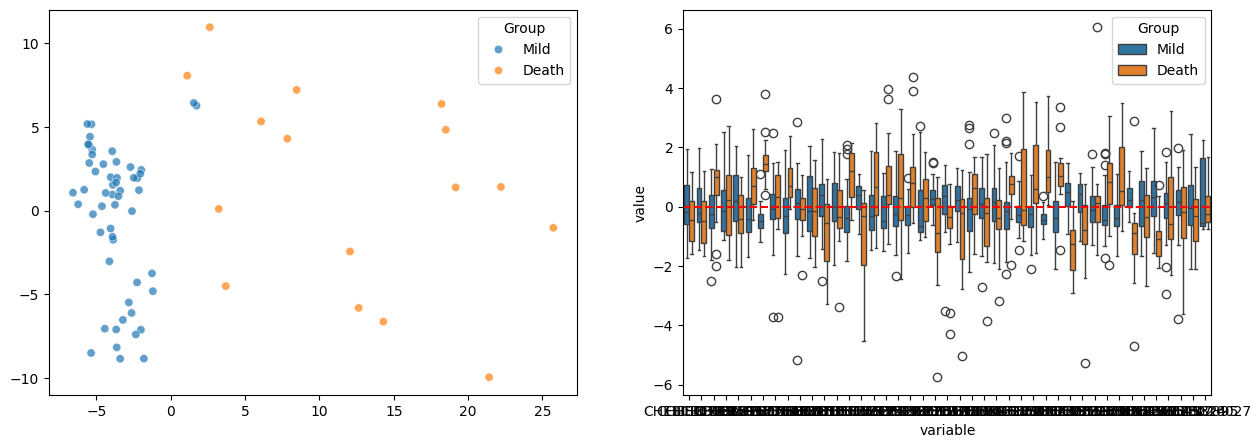

In [216]:
s2542.plot_qc()

In [236]:
s1987 = MTBLSDataset(
    file_path = 'Studies/MTBLS1987', 
    id = 'MTBLS1987', 
    node_name = 'MTBLS1987', 
    md_group = 'Factor Value[Disease]', 
    md_filter = ['COVID-19', 'Healthy Control'],
    maf_sheet=1)

  Sample Name Factor Value[Disease]
0         QC1              COVID-19
1         QC2              COVID-19
2         QC3              COVID-19
3         QC4              COVID-19
4         QC5              COVID-19
                    database_identifier  chemical_formula  \
database_identifier                                         
CHEBI:28875                 CHEBI:28875               NaN   
CHEBI:28716                 CHEBI:28716               NaN   
CHEBI:17351                 CHEBI:17351               NaN   
CHEBI:15843                 CHEBI:15843               NaN   
CHEBI:74547                 CHEBI:74547               NaN   

                                                                smiles  \
database_identifier                                                      
CHEBI:28875                                        CCCCCCCCCCCCCC(O)=O   
CHEBI:28716                                 C(CCCCCCC/C=C\CCCCCC)(=O)O   
CHEBI:17351                              CCCCC\C=C/C\C=C/CCC

C:\Users\cw2019\AppData\Local\Temp\ipykernel_10828\2245921917.py:77: RuntimeWarning: invalid value encountered in scalar divide
  missing_pct = data_filt.isnull().sum().sum() / (data_filt.shape[0] * data_filt.shape[1]) * 100


ValueError: at least one array or dtype is required